# Creating rimed aggregates

You can combine the various tools found in the aggregation/riming package yourself, but I have a written a couple of helpful functions that allow you to do this with just a couple of lines of code. Below, we import the `riming_runs` module that contains those functions, and create two things:
1. The monomer generator `gen`. This is a "factory" that generates aggregates with the specified distribution of properties.
1. The aggregate itself, `agg`. This is created by aggregating the monomers together. For now, we have set riming to 0.

In [5]:
%matplotlib notebook
import riming_runs
from __future__ import print_function

# possible psd values: "exponential", "monodisperse"
# possible mono_type values: "dendrite", "plate", "needle", "rosette", "bullet", "spheroid"
gen = riming_runs.gen_monomer(psd="exponential", size=650e-6, min_size=100e-6, max_size=3000e-6, mono_type="needle", rimed=True, grid_res=20e-6)
agg = riming_runs.generate_rimed_aggregate(gen, N=10, align=True, riming_lwp=0.0, riming_mode="simultaneous")


Let's use `matplotlib` to visualize our newly created dendrite aggregate.

<IPython.core.display.Javascript object>


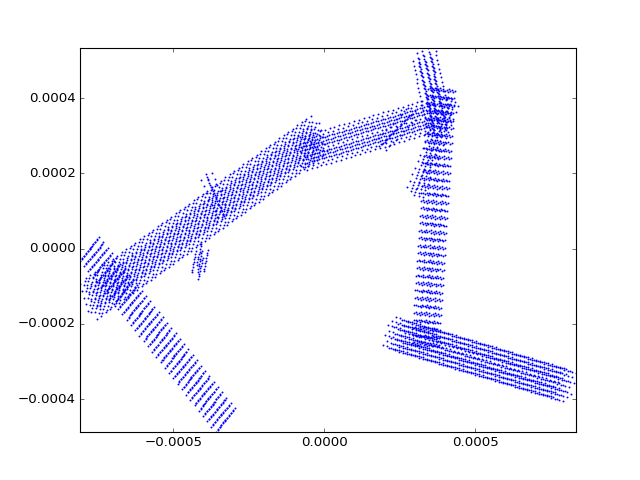

(-0.00048699117838220786, 0.0005330577569499917)

In [6]:
from matplotlib import pyplot as plt

plt.scatter(agg.X[:,0], agg.X[:,2], lw=(0,), s=3)
# set plot limits
plt.gca().set_xlim((agg.X[:,0].min(), agg.X[:,0].max()))
plt.gca().set_ylim((agg.X[:,2].min(), agg.X[:,2].max()))

By changing the `riming_lwp` parameter, you can set the amount of riming. Let's make a rimed needle aggregate.

In [7]:
%matplotlib notebook
import riming_runs

gen = riming_runs.gen_monomer(psd="exponential", size=650e-6, min_size=100e-6, max_size=3000e-6, mono_type="needle", rimed=True)
agg = riming_runs.generate_rimed_aggregate(gen, N=10, align=True, riming_lwp=0.1, riming_mode="simultaneous")


It can be visualized the same way:

<IPython.core.display.Javascript object>


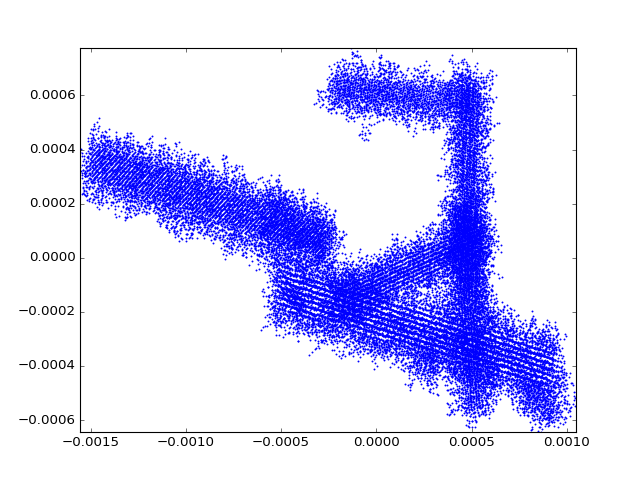

(-0.00064434508556356941, 0.00077545298672532985)

In [8]:
from matplotlib import pyplot as plt

plt.scatter(agg.X[:,0], agg.X[:,1], lw=(0,), s=3)
# set plot limits
plt.gca().set_xlim((agg.X[:,0].min(), agg.X[:,0].max()))
plt.gca().set_ylim((agg.X[:,1].min(), agg.X[:,1].max()))

Here's how to compute the maximum dimension and the vertical projected area:

In [ ]:
import mcs

# This returns the center and the radius of the minimum covering sphere
print(mcs.minimum_covering_sphere(agg.X))
# So the maximum dimension is simply:
print(mcs.minimum_covering_sphere(agg.X)[1]*2)

# This returns the vertically projected area:
print(agg.vertical_projected_area())

List comprehensions are great for making collections of objects by varying parameters. Here's a set of 5 needle aggregates with 3..8 crystals each:


In [ ]:
aggs = [riming_runs.generate_rimed_aggregate(gen, N=n, align=True, riming_lwp=0.1, riming_mode="simultaneous") for n in range(3,9)]

Let's play around with the orientation or aggregates. This example reorients the aggregate to a random orientation and shows the change in the projected area:

In [ ]:
import rotator

agg = riming_runs.generate_rimed_aggregate(gen, N=10, align=True, riming_lwp=0.0, riming_mode="simultaneous")
print("Area before:", agg.vertical_projected_area())
rot = rotator.UniformRotator()
agg.rotate(rot)
print("Area after:", agg.vertical_projected_area())

To align the aggregate horizontally again:

In [ ]:
agg.align()
print("Area now:", agg.vertical_projected_area())

In [ ]:
mass = agg.X.shape[0] * agg.grid_res**3
print(mass)

This should visualize the aggregate:

In [ ]:
agg.visualize()

How to write cell coordinates to a text file:

In [ ]:
import numpy as np
np.savetxt("aggregate_test.txt", agg.X, fmt="%.6e")

Or for a regular grid:

In [ ]:
np.savetxt("aggregate_regular.txt", agg.grid(), fmt="%d") # in multiples of grid_res

Let's make a few aggregates and calculate their properties:

In [ ]:
import numpy as np
gen = riming_runs.gen_monomer(psd="exponential", size=650e-6, min_size=100e-6, max_size=3000e-6, mono_type="dendrite", rimed=True, grid_res=40e-6)
aggs = [riming_runs.generate_rimed_aggregate(gen, N=n, align=True, riming_lwp=0.0, riming_mode="simultaneous") for n in range(3,12)]
rho_i = 917.6
mass = [rho_i*a.X.shape[0]*a.grid_res**3 for a in aggs]
rimed_mass = [rho_i*np.count_nonzero(a.ident==-1)*a.grid_res**3 for a in aggs]
area = [a.vertical_projected_area() for a in aggs]

import mcs
D_max = [mcs.minimum_covering_sphere(a.X)[1]*2 for a in aggs]

Save those values to a file:

In [ ]:
np.savetxt("aggregate_properties.txt", np.vstack((mass, rimed_mass, area, D_max)).T, fmt="%.6e")

Follow the aggregation/riming process and save some values:

In [ ]:
import riming_runs
import mcs

rho_i = 917.6

gen = riming_runs.gen_monomer(psd="monodisperse", size=300e-6, min_size=100e-6, max_size=3000e-6, mono_type="dendrite", rimed=True, grid_res=40e-6)
agg_iter = riming_runs.generate_rimed_aggregate(gen, N=10, align=True, riming_lwp=0.5, riming_mode="subsequent", lwp_div=100, iter=True)
D_max = []
mass = []
for aggs in agg_iter:
    D_max.append(mcs.minimum_covering_sphere(aggs[0].X)[1]*2)
    mass.append(rho_i * aggs[0].X.shape[0] * aggs[0].grid_res**3)
    
print(D_max[-1])
print(mass[-1])


Make a plot of those:

In [ ]:
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np

plt.loglog(D_max, mass, "-+")
n_fit = len(D_max)-5
p = np.polyfit(np.log10(D_max[-n_fit:]), np.log10(mass[-n_fit:]), 1)
b = p[0]
a = 10**p[1]
plt.loglog(D_max[-n_fit:], a*D_max[-n_fit:]**b)
plt.title("a={:.3}, b={:.3}".format(a,b))

Computing the fall velocities:

In [ ]:
%matplotlib notebook
from matplotlib import pyplot as plt
import fallvelocity

gen = riming_runs.gen_monomer(psd="exponential", size=650e-6, min_size=100e-6, max_size=3000e-6, mono_type="dendrite", rimed=True, grid_res=40e-6)
aggs = [riming_runs.generate_rimed_aggregate(gen, N=n, align=True, riming_lwp=0.0, riming_mode="simultaneous") for n in range(3,12)*4]

D_max = [mcs.minimum_covering_sphere(a.X)[1]*2 for a in aggs]
vel_HW = [fallvelocity.fall_velocity(a, method="HW") for a in aggs]
vel_KC = [fallvelocity.fall_velocity(a, method="KC") for a in aggs]

plt.plot(D_max, vel_HW, "b+")
plt.plot(D_max, vel_KC, "g+")